In [33]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

In [34]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat'
    STYLE_IMAGE = 'images/stone_style.jpg'
    CONTENT_IMAGE = 'images/content300.jpg'
    OUTPUT_DIR = 'output/'

In [35]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [36]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """

    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [37]:
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS
    
    return image

In [38]:
def save_image(path, image):
    
    image = image + CONFIG.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

C:\Users\nilay sharma\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


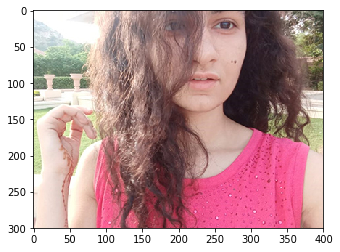

In [40]:
content_image = scipy.misc.imread("images/content.jpg")
imshow(content_image)

In [41]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(tf.transpose(a_C),[n_C,-1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G),[n_C,-1])
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    
    return J_content

In [42]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [43]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(tf.transpose(a_S),[n_C,-1])
    a_G = tf.reshape(tf.transpose(a_G),[n_C,-1])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(2*n_H*n_W*n_C)**2
    
    return J_style_layer

In [44]:
STYLE_LAYERS = [
    ('conv1_1', 0.25),
    ('conv2_1', 0.25),
    ('conv3_1', 0.3),
    ('conv4_1', 0.1),
    ('conv5_1', 0.1)]

In [45]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [46]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content+beta*J_style
    
    return J

In [47]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

C:\Users\nilay sharma\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [48]:
content_image = scipy.misc.imread("images/content.jpg")
content_image = reshape_and_normalize_image(content_image)

C:\Users\nilay sharma\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [49]:
style_image = scipy.misc.imread("images/style.jpg")
style_image = reshape_and_normalize_image(style_image)

C:\Users\nilay sharma\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 300, 400, 3)


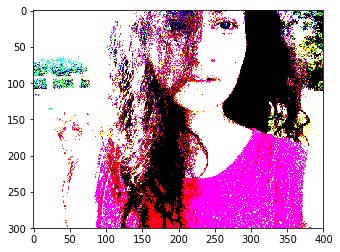

In [65]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [51]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

In [52]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

In [53]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [54]:
J = total_cost(J_content,J_style,10,40)

In [55]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [56]:
def model_nn(sess, input_image, num_iterations = 500):
    
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("images/" + str(i) + ".png", generated_image)
    
    save_image('images/generated_image.jpg', generated_image)
    
    return generated_image

In [58]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3468677400.0
content cost = 9554.022
style cost = 86714540.0


C:\Users\nilay sharma\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


Iteration 20 :
total cost = 645170800.0
content cost = 18050.633
style cost = 16124759.0
Iteration 40 :
total cost = 277242900.0
content cost = 19644.51
style cost = 6926161.5
Iteration 60 :
total cost = 159342720.0
content cost = 20565.592
style cost = 3978426.8
Iteration 80 :
total cost = 107972616.0
content cost = 21222.254
style cost = 2694009.8
Iteration 100 :
total cost = 78818936.0
content cost = 21712.86
style cost = 1965045.2
Iteration 120 :
total cost = 59900670.0
content cost = 22090.229
style cost = 1491994.2
Iteration 140 :
total cost = 47011300.0
content cost = 22415.574
style cost = 1169678.6
Iteration 160 :
total cost = 37972140.0
content cost = 22712.195
style cost = 943625.5
Iteration 180 :
total cost = 31462404.0
content cost = 22986.89
style cost = 780813.4
Iteration 200 :
total cost = 26683374.0
content cost = 23233.248
style cost = 661276.06
Iteration 220 :
total cost = 23073842.0
content cost = 23454.459
style cost = 570982.44
Iteration 240 :
total cost = 2028583

C:\Users\nilay sharma\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


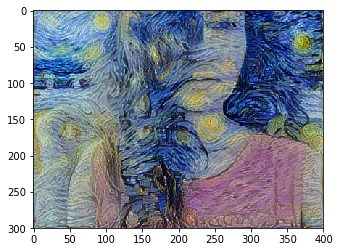

In [67]:
final_image = scipy.misc.imread("images/generated_image.jpg")
imshow(final_image)